In [2]:
# Import all required packages and libraries

import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.core.authentication import MsiAuthentication

In [2]:
print("You are currently using version", azureml.core.VERSION, "of the Azure ML SDK")

You are currently using version 1.17.0 of the Azure ML SDK


In [3]:
# Authenticate into Azure ML Workspace with Managed Service Identity
print('creating MsiAuthentication...')
msi_auth = MsiAuthentication()
print('done creating MsiAuthentication!')

creating MsiAuthentication...
done creating MsiAuthentication!


In [4]:
# Get Workspace from the config file downloaded as config.json from the Azure Portal

ws = Workspace.from_config(auth=msi_auth)

# choose a name for experiment
experiment_name = 'automl-employee-turnover'

experiment=Experiment(ws, experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,93231767-b41d-4cbb-a2d3-2137400dfde2
Workspace,quick-start-ws
Resource Group,MCW-MLOps
Location,eastus
Experiment Name,automl-employee-turnover


In [5]:
# A compute target is required to train models
from azureml.core.compute import ComputeTarget, AmlCompute, AksCompute
from azureml.core.compute_target import ComputeTargetException

# Choose a name for your CPU cluster
cpu_cluster_name = "cpu-cluster"

# Verify that cluster does not exist already
try:
    compute_target = ComputeTarget(workspace=ws, name=cpu_cluster_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',
                                                           max_nodes=4,
                                                           min_nodes=0)
                    
    compute_target = ComputeTarget.create(ws, cpu_cluster_name, compute_config)

compute_target.wait_for_completion(show_output=True)

Found existing cluster, use it.
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


### Load Data

Load the credit card dataset from a csv file containing both training features and labels. The features are inputs to the model, while the training labels represent the expected output of the model. Next, we'll split the data using random_split and extract the training data for the model.

In [6]:
# Training data was uploaded to Azure ML Workspace default datastore and already registered as a dataset

# Get the default datastore
datastore = ws.get_default_datastore()

# Since dtaa is in csv format, get dataset as tabular from the datastore
dataset = Dataset.Tabular.from_delimited_files(path = [(datastore, 'train-dataset/tabular/11-06-2020_102904_UTC/employee-turnover.csv')])

# preview the first 3 rows of the dataset
dataset.take(3).to_pandas_dataframe()                       

,City,Email Domain,EmployeeLeft,Hired through SMTP,Manager Rating of Likelihood to leave,Marked for PHT Program,Most Recent Performance Evaluation,"Social Media Activity (Twitter, Facebook, Instagram)","Survey, Relative, Attitude toward WorkType","Survey, Relative, Attitude toward Workload","Survey, Relative, Peer's Average Attitude toward Manager"
0,Sandaohezi,exblog.jp,0.0,0,1.0,1,59.0,0,2,2,1
1,Bandung,youtu.be,1.0,0,21.0,0,49.0,2,1,2,3
2,Kuala Terengganu,cbslocal.com,0.0,1,1.0,1,51.0,1,3,1,2


In [7]:
# Split dataset into training and validation datasets
training_data, validation_data = dataset.random_split(percentage=0.8, seed=223)

# Identify column to be predicted as label
label_column_name = 'EmployeeLeft'

In [9]:
# Instantiate a AutoMLConfig object. This defines the settings and data used to run the experiment.

automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": 'accuracy',
    "featurization": 'auto',
    "enable_early_stopping": True,
    "max_concurrent_iterations": 4, 
    "experiment_timeout_hours": 1,
    "verbosity": logging.INFO,
    "model_explainability": True
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target = compute_target,
                             training_data = training_data,
                             label_column_name = label_column_name,
                             **automl_settings
                            )

In [11]:
# Submit experiment
remote_run = experiment.submit(automl_config, show_output = False)

Running on remote.


In [12]:
# Wait for experiment to complete. This usually takes 20-30 mins
remote_run.wait_for_completion(show_output=True)


Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Class balancing detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and all classes are balanced in your training data.
              Learn more about imbalanced data: https://aka.ms/AutomatedMLImbalancedData

****************************************************************************************************

TYPE:         Missing feature values imputation
STATUS:       PASSED
DESCRIPTION:  No feature missing values were detected in the training data.
              Learn more about missing value imputation: https://aka.ms/AutomatedMLFeaturization

******************************************************************

{'runId': 'AutoML_9b09fd28-d543-4b5a-9e51-e3a796931772',
 'target': 'cpu-cluster',
 'status': 'Completed',
 'startTimeUtc': '2020-11-10T03:48:39.68178Z',
 'endTimeUtc': '2020-11-10T04:18:02.206361Z',
 'properties': {'num_iterations': '1000',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'accuracy',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': '3',
  'target': 'cpu-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"automl-employee-turnover","subscription_id":"93231767-b41d-4cbb-a2d3-2137400dfde2","resource_group":"MCW-MLOps","workspace_name":"quick-start-ws","region":"eastus","compute_target":"cpu-cluster","spark_service":null,"azure_service":"remote","_local_managed_run_id":null,"many_models":false,"pipeline_fetch_max_batch_size":1,"iterations":1000,"primary_metric":"accuracy","task_type":"classification","data_script":null,"validation_size":0.0,"n_cross_validations":3,"y_min":null,"y_max":null,"num_classe

In [15]:
# Get the parent run id of the experiment
remote_run.run_id


'AutoML_9b09fd28-d543-4b5a-9e51-e3a796931772'

In [5]:
# Instantiate AutoMLRun object in order to get AutoML related metrics and output
# Last good runs 'AutoML_da7d5f0a-9ac4-4330-bb94-818a8ec80b26' , 'AutoML_9b09fd28-d543-4b5a-9e51-e3a796931772'

from azureml.train.automl.run import AutoMLRun

automl_run = AutoMLRun(experiment = experiment, run_id = remote_run.run_id)

In [6]:
# Retrieve the best model and associated run id ad best_run
best_run, fitted_model = automl_run.get_output()

In [7]:
# List all the features engineered by Auto ML
fitted_model.named_steps['datatransformer'].get_engineered_feature_names()

['City_CharGramCountVectorizer_bandung',
 'City_CharGramCountVectorizer_beaverlodge',
 'City_CharGramCountVectorizer_ell',
 'City_CharGramCountVectorizer_kuala terengganu',
 'City_CharGramCountVectorizer_liancheng',
 'City_CharGramCountVectorizer_nuoxizhi',
 'City_CharGramCountVectorizer_sandaohezi',
 'Email Domain_CharGramCountVectorizer_cbslocal.com',
 'Email Domain_CharGramCountVectorizer_exblog.jp',
 'Email Domain_CharGramCountVectorizer_nps.gov',
 'Email Domain_CharGramCountVectorizer_sciencedaily.com',
 'Email Domain_CharGramCountVectorizer_springer.com',
 'Email Domain_CharGramCountVectorizer_upenn.edu',
 'Email Domain_CharGramCountVectorizer_usda.gov',
 'Email Domain_CharGramCountVectorizer_youtu.be',
 'Hired through SMTP_ModeCatImputer_LabelEncoder',
 'Marked for PHT Program_ModeCatImputer_LabelEncoder',
 'Social Media Activity (Twitter, Facebook, Instagram)_CharGramCountVectorizer_0',
 'Social Media Activity (Twitter, Facebook, Instagram)_CharGramCountVectorizer_1',
 'Social 

In [8]:
# Get featurization summary of all input features
fitted_model.named_steps['datatransformer'].get_featurization_summary()

[{'RawFeatureName': 'City',
  'TypeDetected': 'Categorical',
  'Dropped': 'No',
  'EngineeredFeatureCount': 7,
  'Transformations': ['StringCast-CharGramCountVectorizer']},
 {'RawFeatureName': 'Email Domain',
  'TypeDetected': 'Categorical',
  'Dropped': 'No',
  'EngineeredFeatureCount': 8,
  'Transformations': ['StringCast-CharGramCountVectorizer']},
 {'RawFeatureName': 'Hired through SMTP',
  'TypeDetected': 'Categorical',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['ModeCatImputer-StringCast-LabelEncoder']},
 {'RawFeatureName': 'Marked for PHT Program',
  'TypeDetected': 'Categorical',
  'Dropped': 'No',
  'EngineeredFeatureCount': 1,
  'Transformations': ['ModeCatImputer-StringCast-LabelEncoder']},
 {'RawFeatureName': 'Social Media Activity (Twitter, Facebook, Instagram)',
  'TypeDetected': 'Categorical',
  'Dropped': 'No',
  'EngineeredFeatureCount': 8,
  'Transformations': ['StringCast-CharGramCountVectorizer']},
 {'RawFeatureName': 'Survey, Relative, 

In [20]:
# Display model properties

from pprint import pprint

def print_model(model, prefix=""):
    for step in model.steps:
        print(prefix + step[0])
        if hasattr(step[1], 'estimators') and hasattr(step[1], 'weights'):
            pprint({'estimators': list(
                e[0] for e in step[1].estimators), 'weights': step[1].weights})
            print()
            for estimator in step[1].estimators:
                print_model(estimator[1], estimator[0] + ' - ')
        else:
            pprint(step[1].get_params())
            print()

print_model(fitted_model)

datatransformer
{'allow_chargram': None,
 'enable_dnn': None,
 'enable_feature_sweeping': None,
 'feature_sweeping_config': None,
 'feature_sweeping_timeout': None,
 'featurization_config': None,
 'force_text_dnn': None,
 'is_cross_validation': None,
 'is_onnx_compatible': None,
 'logger': None,
 'observer': None,
 'task': None,
 'working_dir': None}

prefittedsoftvotingclassifier
{'estimators': ['1', '0', '27', '32', '26', '29', '15'],
 'weights': [0.15384615384615385,
             0.15384615384615385,
             0.15384615384615385,
             0.07692307692307693,
             0.07692307692307693,
             0.07692307692307693,
             0.3076923076923077]}

1 - maxabsscaler
{'copy': True}

1 - xgboostclassifier
{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 100,
 'n_jobs': 1

In [21]:
# Explain model

from azureml.interpret import ExplanationClient

client = ExplanationClient.from_run(best_run)
engineered_explanations = client.download_model_explanation(raw=False)

print(engineered_explanations.get_feature_importance_dict())

{'Survey, Relative, Attitude toward WorkType_CharGramCountVectorizer_1': 0.9418254909646459, "Survey, Relative, Peer's Average Attitude toward Manager_CharGramCountVectorizer_1": 0.6860528911302267, 'Manager Rating of Likelihood to leave_MeanImputer': 0.46837824411075935, 'City_CharGramCountVectorizer_bandung': 0.45799893975782313, 'Survey, Relative, Attitude toward WorkType_CharGramCountVectorizer_2': 0.40795208618625467, 'Survey, Relative, Attitude toward Workload_CharGramCountVectorizer_1': 0.3536603643073425, 'City_CharGramCountVectorizer_liancheng': 0.28012961100746664, "Survey, Relative, Peer's Average Attitude toward Manager_CharGramCountVectorizer_2": 0.2570319321233441, 'Marked for PHT Program_ModeCatImputer_LabelEncoder': 0.254615777311015, 'Email Domain_CharGramCountVectorizer_youtu.be': 0.21337854978811102, 'City_CharGramCountVectorizer_beaverlodge': 0.20333854814347616, 'Survey, Relative, Attitude toward Workload_CharGramCountVectorizer_2': 0.14507755374907264, 'Most Recen

## Test the fitted model

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [22]:
# convert the test data to dataframe
X_test_df = validation_data.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
y_test_df = validation_data.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

In [23]:
# call the predict functions on the model
y_pred = fitted_model.predict(X_test_df)
y_pred

array([1., 1., 1., ..., 1., 1., 1.])

### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values 
from the trained model that was returned.

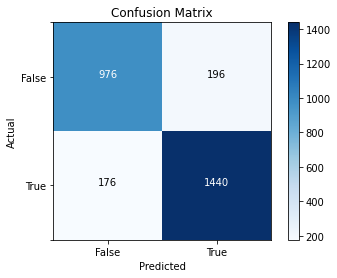

In [24]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

cf =confusion_matrix(y_test_df.values,y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()

In [25]:
# Collect model details in order to prepare for Model registry and deployment
# Get the file names and paths of model name, model path, conda dependency yaml file and scoring file
# All of these files are auto generated by Auto ML
best_run.get_file_names()

['accuracy_table',
 'automl_driver.py',
 'azureml-logs/55_azureml-execution-tvmps_eb9a88233ace0912a2c3e2241b3d3b3d2f846cc3f73f1e0141cb484b25e54cff_d.txt',
 'azureml-logs/65_job_prep-tvmps_eb9a88233ace0912a2c3e2241b3d3b3d2f846cc3f73f1e0141cb484b25e54cff_d.txt',
 'azureml-logs/70_driver_log.txt',
 'azureml-logs/75_job_post-tvmps_eb9a88233ace0912a2c3e2241b3d3b3d2f846cc3f73f1e0141cb484b25e54cff_d.txt',
 'azureml-logs/process_info.json',
 'azureml-logs/process_status.json',
 'confusion_matrix',
 'explanation/11cb1ac8/classes.interpret.json',
 'explanation/11cb1ac8/expected_values.interpret.json',
 'explanation/11cb1ac8/features.interpret.json',
 'explanation/11cb1ac8/global_names/0.interpret.json',
 'explanation/11cb1ac8/global_rank/0.interpret.json',
 'explanation/11cb1ac8/global_values/0.interpret.json',
 'explanation/11cb1ac8/local_importance_values.interpret.json',
 'explanation/11cb1ac8/per_class_names/0.interpret.json',
 'explanation/11cb1ac8/per_class_rank/0.interpret.json',
 'explanation/11cb1ac8/per_class_values/0.interpret.json',
 'explanation/11cb1ac8/rich_metadata.interpret.json',
 'explanation/11cb1ac8/visualization_dict.interpret.json',
 'explanation/6b20bd69/classes.interpret.json',
 'explanation/6b20bd69/expected_values.interpret.json',
 'explanation/6b20bd69/features.interpret.json',
 'explanation/6b20bd69/global_names/0.interpret.json',
 'explanation/6b20bd69/global_rank/0.interpret.json',
 'explanation/6b20bd69/global_values/0.interpret.json',
 'explanation/6b20bd69/local_importance_values.interpret.json',
 'explanation/6b20bd69/per_class_names/0.interpret.json',
 'explanation/6b20bd69/per_class_rank/0.interpret.json',
 'explanation/6b20bd69/per_class_values/0.interpret.json',
 'explanation/6b20bd69/rich_metadata.interpret.json',
 'explanation/6b20bd69/visualization_dict.interpret.json',
 'logs/azureml/111_azureml.log',
 'logs/azureml/azureml_automl.log',
 'logs/azureml/dataprep/python_span_29ce64ef-8221-45c1-8ded-20fc23b6a0b7.jsonl',
 'logs/azureml/dataprep/python_span_b44005b7-ca3c-4fd9-9359-5625b3287ede.jsonl',
 'logs/azureml/job_prep_azureml.log',
 'logs/azureml/job_release_azureml.log',
 'outputs/conda_env_v_1_0_0.yml',
 'outputs/env_dependencies.json',
 'outputs/model.pkl',
 'outputs/pipeline_graph.json',
 'outputs/scoring_file_v_1_0_0.py']

In [26]:
# Check min cpu cores needed for the model
cpu_cores=int(best_run.get_properties().get('num_cores'))
cpu_cores

2

In [27]:
# Check model size
model_size_gb=int(best_run.get_properties().get('model_size_on_disk'))/(1024*1024*1024)
model_size_gb

0.001948588527739048

In [28]:
# Register the model identified by the best AutoML run
from azureml.core.model import Model
from azureml.core.resource_configuration import ResourceConfiguration

model = best_run.register_model(model_name='employee-turnover',
                                model_path='outputs/model.pkl',
                                model_framework=Model.Framework.SCIKITLEARN,
                                model_framework_version='0.22.1',
                                resource_configuration=ResourceConfiguration(cpu=2, memory_in_gb=0.5),
                                description='employee-turnover best model created with AutoML',
                                tags={'area': 'employee turnover', 'type': 'classification'})


print(model.name, model.id, model.version, sep='\t')

employee-turnover	employee-turnover:5	5


In [49]:
# Prepare configuration from Inferencing deployment
from azureml.core.environment import Environment
from azureml.core.model import InferenceConfig

env = Environment.from_conda_specification(name='employee-turnover-env', file_path='outputs/conda_env_v_1_0_0.yml')

inference_config = InferenceConfig(entry_script='outputs/scoring_file_v_1_0_0.py',
                                    environment=env)

In [47]:
# Model will be deployed as a real time webservice on a AKS Cluster
# First create AKS Cluster

# Choose a name for your AKS cluster
aks_name = 'aks-cluster-prod' 

# Verify that cluster does not exist already
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # Use the default configuration (can also provide parameters to customize)
    prov_config = AksCompute.provisioning_configuration()

    # Create the cluster
    aks_target = ComputeTarget.create(workspace=ws, 
                                    name=aks_name, 
                                    provisioning_configuration = prov_config)

if aks_target.get_status() != "Succeeded":
    aks_target.wait_for_completion(show_output=True)

Found existing cluster, use it.


In [52]:
# Deploy model as a webservice on the AKS Cluster
# no code deployment is used here
service_name = 'employee-turnover-service'
service = Model.deploy(ws, service_name, [model], inference_config, deployment_target=aks_target)
service.wait_for_deployment(show_output=True)
print(service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.............................................................................................................................................................
Succeeded
AKS service creation operation finished, operation "Succeeded"
Healthy


In [55]:
# Get deployed webservice scoring URI and key
from azureml.core.webservice import Webservice
endpoint = Webservice(workspace=ws, name='employee-turnover-service')
primary, secondary = endpoint.get_keys()
print(endpoint.scoring_uri)
print(endpoint.swagger_uri)
print(primary)

http://52.249.252.28:80/api/v1/service/employee-turnover-service/score
http://52.249.252.28:80/api/v1/service/employee-turnover-service/swagger.json
XLv3lVdQuhbpWkHqbmxqDSc9CBkaDIgr


In [65]:
# Test model webservice
# Below is input sample taken from scoring script
# input_sample = pd.DataFrame({"City": pd.Series(["Sandaohezi"], dtype="object"), "Email Domain": pd.Series(["exblog.jp"], dtype="object"), "Hired through SMTP": pd.Series(["0"], dtype="int64"), "Manager Rating of Likelihood to leave": pd.Series(["1.0"], dtype="float64"), "Marked for PHT Program": pd.Series(["1"], dtype="int64"), "Most Recent Performance Evaluation": pd.Series(["59.0"], dtype="float64"), "Social Media Activity (Twitter, Facebook, Instagram)": pd.Series(["0"], dtype="int64"), "Survey, Relative, Attitude toward WorkType": pd.Series(["2"], dtype="int64"), "Survey, Relative, Attitude toward Workload": pd.Series(["2"], dtype="int64"), "Survey, Relative, Peer's Average Attitude toward Manager": pd.Series(["1"], dtype="int64")})

import requests
import json

# Two sets of data to score, so we get two results back
data = {"data":
        [
            [
                'Nuoxizhi','youtu.be',1,1.0,0,51.0,0,3,5,1
            ],
            [
                'Ell','cbslocal.com',0,3.0,0,63.0,2,3,2,3
            ]
        ]
        }
# Convert to JSON string
input_data = json.dumps(data)

# Set the content type
headers = {'Content-Type': 'application/json'}
# If authentication is enabled, set the authorization header
headers['Authorization'] = f'Bearer {primary}'

# Make the request and display the response
resp = requests.post(endpoint.scoring_uri, input_data, headers=headers)
print(resp.text)

"{\"result\": [0.0, 1.0]}"
